# Jet Extension


The purpose of this notebook is to explore the leading EOFs of the 850 hPa circulation, expressed through the streamfunction $\psi$.
This should provide insight as to the behavior of the SALLJ and hopefully may help us understand why the 2015-16 rainfall over the Lower Paraguay River Basin was so intense.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from eofs.xarray import Eof
from scipy.stats import spearmanr, pearsonr
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
import cartopy.feature
from paraguayfloodspy.xrutil import *
import paraguayfloodspy.visualize as viz
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

## Setup

Load the parameters of the data

In [2]:
%run ../config/RioParaguay.mk
%run ../config/WeatherTypes.mk
%run ../config/Time.mk
print(RPEAST, RPWEST, RPSOUTH, RPNORTH)
print(WTEAST, WTWEST, WTSOUTH, WTNORTH)
print(SYEAR, EYEAR)

304.75 301.25 -26.75 -22.75
315 295 -30 -15
1979 2016


In [3]:
savefigs = True

Read in the raw data.
This data is the 850 hPa streamflow function $\psi$ which has been filtered to take the anomalies against the monthly 1980-2010 climatologies.

In [4]:
psi = SelectData(xr.open_dataset('../data/derived/psi_850.nc'),
                    extent=[WTWEST, WTEAST, WTSOUTH, WTNORTH], y_low_high=True)
prcp = xr.open_dataset('../data/derived/precip.nc')

## EOFs

The next step of our analysis is to take the leading EOFs of the streamfunction.
We'll take out seasonality.

In [5]:
solver = Eof(psi['anomaly'], center=True)

Let's look at the variance explained.
Note that the python indexing of the EOFs begins at zero but most people are used to seeing them begin at 1.

In [14]:
%run ../config/WeatherTypes.mk
var_xpl = solver.varianceFraction(neigs=8).values
neof = np.min(np.where(np.cumsum(var_xpl) >= WT_PROP)) + 1
print(neof)

4


/usr/local/miniconda3/envs/pyfloods/lib/python3.6/site-packages/eofs/xarray.py:413: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  attrs={'long_name': 'eof_mode_number'})


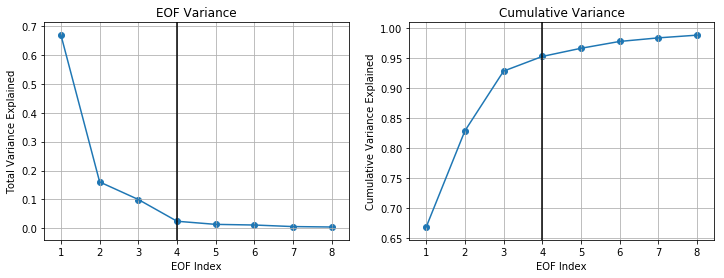

In [17]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.xlabel("EOF Index")
plt.ylabel("Total Variance Explained")
plt.plot(np.arange(var_xpl.size) + 1, var_xpl)
plt.scatter(np.arange(var_xpl.size) + 1, var_xpl)
plt.title("EOF Variance")
plt.axvline(neof, color = 'black')
plt.grid(True)
plt.subplot(1,2,2)
plt.xlabel("EOF Index")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Variance")
plt.plot(np.arange(var_xpl.size) + 1, np.cumsum(var_xpl))
plt.scatter(np.arange(var_xpl.size) + 1, np.cumsum(var_xpl))
plt.grid(True)
plt.axvline(neof, color = 'black')
if savefigs:
    plt.savefig("../figs/PSI_Var_Explained.pdf", bbox_inches='tight')

In [ ]:
loading = solver.eofs(neofs=neof)
loading['mode'] += 1

Let's also visualize the loadings

In [ ]:
fig, axes = viz.SetupAxes(nax=neof, ncol=neof, proj=ccrs.PlateCarree(), figsize=(16, 3.5))
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.175, 0.0125, 0.65])
for i,m in enumerate(loading['mode'].values):
    ax = viz.GetRowCol(i, axes)
    ax.set_title("EOF {}".format(m))
    sub = loading.sel(mode = m)
    X, Y = np.meshgrid(sub.lon, sub.lat)
    C = ax.contourf(X, Y, sub, transform = ccrs.PlateCarree(), 
                     cmap = "PuOr", levels=np.linspace(-0.3, 0.3, 13))

cb = plt.colorbar(C, cax=cbar_ax)
cb.set_label("EOF Loading", rotation=270)
cb.ax.get_yaxis().labelpad = 15
viz.FormatAxes(axes, coast=True, grid=False, border=True, extent=[WTWEST, WTEAST, WTSOUTH, WTNORTH])
if savefigs:
    plt.savefig("../figs/PSI_EOF_Loadings.pdf", bbox_inches='tight')    

Looking a this, we see that EOF 2 represents a SALLJ extension event, but that EOF 3 modulates whether it is a "Chaco Jet Event" 
or "No Chaco Jet Event"

In [ ]:
print("Chaco Jet Event")
Image(url= "http://www.eumetrain.org/satmanu/CMs/Sallj/media/images/CJEk.png", height=150)

In [ ]:
print("No Chaco Jet Event")
Image(url= "http://www.eumetrain.org/satmanu/CMs/Sallj/media/images/CM_SALLJ_NCJEk.png", height=150)

## PC Time Series

Now let's look at the time series of these two key PCs (2 and 3) and compare them to the rainfall field to see if it really matches our expectations.

In [ ]:
pcs = solver.pcs(npcs=neof, pcscaling=1)
pcs['mode'] += 1
pcs = pcs.to_pandas()

Now let's also create two time series of rainfall -- one over our Paragauy River Basin, and the other over the Chaco Jet Event region.

In [ ]:
prcp_rpy = pd.read_csv("../data/derived/rainfall_rpy.csv", index_col='time')['raw']
prcp_rpy = pd.DataFrame(prcp_rpy.rename('prcp_rpy'))

In [ ]:
cje_rgn = {'lonmin': 299.25, 'lonmax': 302.75, 'latmin': -34.75, 'latmax': -30.75}
prcp_cje = prcp['raw'].sel(lon = slice(cje_rgn['lonmin'], cje_rgn['lonmax']), 
                    lat = slice(cje_rgn['latmin'], cje_rgn['latmax'])).mean(dim=['lon', 'lat'])
prcp_cje = prcp_cje.to_pandas()
prcp_cje = pd.DataFrame({'prcp_cje': prcp_cje})

In [ ]:
pc_rain = pcs.join(prcp_rpy).join(prcp_cje)
pc_rain = pc_rain.dropna()
pc_rain.head()

Correlation is obviously a limited tool, but let's see how the EOFs are correlated (daily time step) with the rainfall data

In [ ]:
print('Spearman rank correlation between URU and RPY Data: {:4f}'.format(spearmanr(pc_rain[['prcp_cje']], pc_rain[['prcp_rpy']])[0]))
print('Pearson correlation between URU and RPY Data: {:4f}'.format(pearsonr(pc_rain[['prcp_cje']], pc_rain[['prcp_rpy']])[0][0]))
for i in range(neof):
    print('Spearman rank correlation between EOF {} and RPY Data: {:3f}'.format(i+1, spearmanr(pc_rain[[i+1]], pc_rain[['prcp_rpy']])[0]))
    print('Pearson correlation between EOF {} and RPY Rainfall: {:3f}'.format(i+1, pearsonr(pc_rain[[i+1]], pc_rain[['prcp_rpy']])[0][0]))
    print('Spearman rank correlation between EOF {} and CJE Data: {:3f}'.format(i+1, spearmanr(pc_rain[[i+1]], pc_rain[['prcp_cje']])[0]))
    print('Pearson correlation between EOF {} and CJE Rainfall: {:3f}'.format(i+1, pearsonr(pc_rain[[i+1]], pc_rain[['prcp_cje']])[0][0]))

This correlation analysis supports our conjecture (based on looking at the EOF loadings) that EOF 2 and EOF 3 strongly modulate rainfall over the Paraguay River Basin.

## KNN

Let's focus on these two EOFs to get a bit better sense of how strongly they modulate intense rainfall.

In [ ]:
plt.figure(figsize=(11,8))
S = plt.scatter(pc_rain[[2]], pc_rain[[3]], s=5*pc_rain[['prcp_rpy']], c=pc_rain[['prcp_rpy']], alpha=0.4)
plt.xlabel("EOF 2")
plt.ylabel("EOF 3")
plt.title("Modulation of Rainfall by EOFs 2 and 3")
cb = plt.colorbar()
cb.set_label("Daily Rainfall [mm/day]")

It definitely looks like the top-left quadrant leads to higher probability of intense rainfall, but the plot is a bit crowded.
To get around this, let's do a nearest-neighbors regression -- this is essentially taking the expected rainfall given EOF 2 and EOF 3 -- at a grid of points.
Start by defining this grid and the fit to use:

In [ ]:
X = pc_rain[[2, 3]].values
neigh = KNeighborsRegressor(n_neighbors=100)
x = np.arange(-2.5, 2.5, .1)
x,y = np.meshgrid(x,x)
Xnew = np.array([np.hstack(x), np.hstack(y)]).transpose()
X1new = np.reshape(Xnew[:,0], x.shape)
X2new = np.reshape(Xnew[:,1], x.shape)
y = pc_rain[['prcp_rpy']].values
knnfit = neigh.fit(X,y)

Then create the plots

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.175, 0.02, 0.65])
# Left Plot
ax = axes[0]
y = pc_rain[['prcp_rpy']].values
knnfit = neigh.fit(X,y)
ynew = knnfit.predict(Xnew)
ynew = np.reshape(ynew, x.shape)
C = ax.pcolormesh(X1new, X2new, ynew, vmin=0, vmax=14)
ax.set_xlabel("EOF 2")
ax.set_ylabel("EOF 3")
ax.set_title("Lower Paraguay River Basin")
ax = axes[1]
y = pc_rain[['prcp_cje']].values
knnfit = neigh.fit(X,y)
ynew = knnfit.predict(Xnew)
ynew = np.reshape(ynew, x.shape)
C = ax.pcolormesh(X1new, X2new, ynew, vmin=0, vmax=14)
ax.set_xlabel("EOF 2")
ax.set_ylabel("EOF 3")
cb = plt.colorbar(C, cax=cbar_ax)
cb.set_label("Rainfall [mm/d]")
ax.set_title("Chaco Jet Extension Region")
if savefigs:
    plt.savefig("../figs/knn_rainfall_EOF.pdf", bbox_inches='tight')

So we can see that in this limited-dimension space, EOF 2 controls the potential for rainfall but EOF 3 controls whether it is a Chaco Jet Event or No Chaco Jet Event.
This is exactly what we thought above!
When EOF1 is positive (no jet), there is no rainfall in either region and when EOF1 is negative (jet) there is rainfall somewhere.
However, when EOF2 is negative the jet extends far to the South and the rainfall occurs over Uruguay; when EOF2 is positive the jet doesn't penetrate and the intense rainfall occurs in Paraguay.
Just to make sure we're not tricking ourselves, let's composite rainfall for four cases:
1. EOF1 > 1, EOF2 > 1; 
2. EOF1 < -1, EOF2 > 1;
3. EOF1 > 1, EOF2 < -1;
4. EOF1 < -1, EOF2 < -1.

In [ ]:
case_1 = np.logical_and(pc_rain[2] > 1, pc_rain[3] > 1)
case_1 = pc_rain.loc[case_1].index
case_2 = np.logical_and(pc_rain[2] < -1, pc_rain[3] > 1)
case_2 = pc_rain.loc[case_2].index
case_3 = np.logical_and(pc_rain[2] > 1, pc_rain[3] < -1)
case_3 = pc_rain.loc[case_3].index
case_4 = np.logical_and(pc_rain[2] < -1, pc_rain[3] < -1)
case_4 = pc_rain.loc[case_4].index

In [ ]:
fig, axes = viz.SetupAxes(nax=4, ncol=4, proj=ccrs.PlateCarree(), figsize=(16, 4.5))
fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.97, 0.1, 0.015, 0.8])
for i,case in enumerate([case_1, case_2, case_3, case_4]):
    selector = lambda ds: ds.sel(lon = slice(285, 315), lat = slice(-40, -5)).sel(time = case).mean(dim= 'time')
    ax = viz.GetRowCol(i, axes)
    ax.set_title("Case {}".format(i+1))
    sub = selector(prcp['raw'])
    Xp, Yp = np.meshgrid(sub.lon, sub.lat)
    sub = np.ma.masked_invalid(sub)
    C = ax.contourf(Xp, Yp, sub, transform = ccrs.PlateCarree(), 
                    levels=np.linspace(0,12,7), extend='max', cmap="Greens")
cb = plt.colorbar(C, cax=cbar_ax)
cb.set_label("Rainfall [mm/d]")
for ax in axes.flat:
    ax.coastlines()
    ax.set_extent((285, 315, -40, -5))
    ax.add_feature(cartopy.feature.BORDERS)

So looking at this, we can see that for Case 1 and Case 3 (no strong jet event) the Amazon basin experiences strong rainfall and SESA experiences very little rainfall.
However, during Case 2 and Case 4, during strong SALLJ occurrences, rainfall over the Amazon is reduced and rainfall below 20S is enhanced.
For case 2, this rainfall occurs over the Paraguay River Basin and for case 4 it occurs further South, over NE Argentina and Uruguay.

Just to check ourselves again, let's calculate the correlation of EOF 3 and the difference between the RPY rainfall box and CJE box.

In [ ]:
raindiff = pd.DataFrame({'prcp_diff': pc_rain['prcp_rpy'] - pc_rain['prcp_cje']}).join(pc_rain[[3]])
raindiff = raindiff.dropna()
rho, p = spearmanr(raindiff[['prcp_diff']], raindiff[[3]])
print("Spearman rank correlation between this difference and EOF 3 is {:3f}, p-value {}".format(rho, p))

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(raindiff[[3]], raindiff[['prcp_diff']], alpha=0.3)
plt.xlabel("EOF 3")
plt.ylabel("Rainfall Difference [mm/d]")

## S2S Controls

The results above suggest that, to a reasonable degree of approximation, differences in rainfall location (Paraguay River Basin or NE Argentina/Uruguay) are linked (in agreement with the literature) to different types of jet events.
Using the chosen domain, this corresponds to EOFs 2 and 3 of the NDJF streamfunction field (which is for all intents and purposes quite close to the geopotential height field).
To understand the 2015-16 event, we will explore: the time evolution of these two EOFs, their association with the observed rainfall, and seasonal (ENSO) and sub-seasonal (ENSO) control of their evolution.
To do that we'll have to resample the PC time series to monthly resolution.

In [ ]:
ensoraw = pd.read_csv("../data/accessed/indices/monthly_indices.csv", index_col='time', parse_dates=True)
enso = ensoraw[['nino_34']]
enso['year'] = enso.index.year
enso['month'] = enso.index.month
enso = enso.loc[np.in1d(enso['month'], [11, 12, 1, 2])]
enso = enso.groupby(['year', 'month']).mean()

In [ ]:
ensopc = pcs[[2,3]].copy()
ensopc['year'] = ensopc.index.year
ensopc['month'] = ensopc.index.month
ensopc = ensopc.groupby(['year', 'month']).mean()
ensopc.head()
ensopc = ensopc.join(enso)

In [ ]:
sns.pairplot(ensopc, kind='reg')

So from this we can see that El Niño events are associated with enhanced monthly-mean SALLJ activity (EOF 2)  but that the association with EOF 3 is weak.

In [ ]:
spearmanr(ensopc[[2]], ensopc[['nino_34']])

In [ ]:
mjo = pd.read_csv("../data/accessed/indices/daily_indices.csv",parse_dates=True, index_col='time')
mjo = mjo.join(pcs[[2,3]]).dropna()

In [ ]:
sns.pairplot(mjo[['RMM1', 'RMM2', 2, 3]], kind='reg', diag_kind="kde", plot_kws={'marker': '.'})

This suggests that at daily time scales, the strongest modulation is of RMM1 on EOF 3 (CJE/NCJE).

In [ ]:
spearmanr(mjo[[3]], mjo.RMM1)

## NDJF 2015-16

Finally we ask whether, given these findings as to the climatological relationship between EOF 2 and 3, and the MJO and ENSO, they are likely drivers of the observed anomalies.
We'll filter out synoptic variances by taking the 7-day rolling averages of the MJO and EOFs (lines) but also will plot the unfiltered values (dots).

In [ ]:
subr = mjo.rolling(7, center=True).mean()['2015-11-01':'2016-02-29']
sub = mjo['2015-11-01':'2016-02-29']
esub = ensoraw['2015-11-01':'2016-03-01']
rsub = pc_rain['2015-11-01':'2016-02-29']
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(16,12))
ax = axes[0]
ax.plot(subr.index, subr.RMM1, label="MJO RMM1", linewidth=3)
ax.scatter(sub.index, sub.RMM1, label="MJO RMM1", s=6)
ax.plot(esub.index, esub['nino_34'], label="NINO 3.4", linewidth=3)
ax.set_title("Selected S2S Predictors")
ax.legend()
ax.grid(True)
ax.axhline(0, c='black')
ax = axes[1]
ax.plot(subr.index, subr[[2]], label="EOF 2", linewidth=3)
ax.scatter(sub.index, sub[[2]], label="EOF 2", s=6)
ax.plot(subr.index, subr[[3]], label="EOF 3", linewidth=3)
ax.scatter(sub.index, sub[[3]], label="EOF 3", s=6)
ax.axhline(0, c='black')
ax.set_title("Leading EOFs of Domain Streamfunction")
ax.legend()
ax.grid(True)
ax = axes[2]
ax.plot(rsub.index, rsub[['prcp_rpy']], label="RPY", linewidth=2)
ax.plot(rsub.index, rsub[['prcp_cje']], label="CJE", linewidth=2)
ax.axhline(0, c='black')
ax.set_title("Rainfall")
ax.legend()
ax.grid(True)
if savefigs:
    plt.savefig("../figs/ENSO_MJO_EOF_PRCP_Time_Series.pdf", bbox_inches='tight')

Looking at this, we can see that the expected relationships held:

- The strong El Niño led to a generally strongly negative EOF 2 (red) during NDJF 2015-16, leading to strong and repeated jet activity.
- MJO RMM1 was positive during much of the season, leading to a positive EOF 3 (favoring no-chaco jet extension and rainfall over Paraguay) but dipped during early January with a corresponding shift in EOF3.
- The effect of MJO RMM1 on EOF2 probably has a lag and correlation could be increased by addressing this lag
- The negative turn in MJO RMM1 led, after a short pause, to a negative turn in EOF2; there was also positive spell of EOF2 which may be unrelated.